<a href="https://colab.research.google.com/github/sushant-97/Transformer-From-Scratch/blob/main/Transformer_Models_with_Attention_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Lesson 01: Obtaining Data
- Lesson 02: Text Normalization
- Lesson 03: Vectorization and Making Datasets
- Lesson 04: Positional Encoding Matrix
- Lesson 05: Positional Encoding Layer
- Lesson 06: Transformer Building Blocks
- Lesson 07: Transformer Encoder and Decoder
- Lesson 08: Building a Transformer
- Lesson 09: Preparing the Transformer Model for Training
- Lesson 10: Training the Transformer
- Lesson 11: Inference from the Transformer Model
- Lesson 12: Improving the Model


## 01: Obtaining Data

In [1]:
import pathlib

import tensorflow as tf

# download dataset from https://www.manythings.org/anki/
text_file = tf.keras.utils.get_file(
    fname = "fra-eng.zip",
    origin = "http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
    extract = True,
)

# showing where file is located
text_file = pathlib.Path(text_file).parent / "fra-eng.zip"
print(text_file)

3423204/3423204 [==============================] - 0s 0us/step
/root/.keras/datasets/fra-eng.zip


## 02: Text Normalization

In [8]:
import pathlib
import pickle
import random
import re
import unicodedata

import tensorflow as tf

# download dataset provided by Anki: https://www.manythings.org/anki/
text_file = tf.keras.utils.get_file(
    fname="fra-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "fra.txt"

def normalize(line):
    """Normalize a line of text and split into two at the tab character"""
    line = unicodedata.normalize("NFKC", line.strip().lower())
    line = re.sub(r"^([^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(\s[^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(?!\s)([^ \w])$", r" \1", line)
    line = re.sub(r"(?!\s)([^ \w]\s)", r" \1", line)
    eng, fra = line.split("\t")
    fra = "[start] " + fra + " [end]"
    return eng, fra

# normalize each line and separate into English and French
with open(text_file) as fp:
    text_pairs = [normalize(line) for line in fp]

# print some samples
for _ in range(5):
    print(random.choice(text_pairs))

with open("/content/drive/MyDrive/00_Data_Science/PROJECTS/TransformerFromScratch/text_pairs.pickle", "wb") as fp:
    pickle.dump(text_pairs, fp)

('he is used to eating in a rush .', "[start] il a l'habitude de manger à la hâte . [end]")
('is that unconstitutional ?', '[start] est-ce inconstitutionnel  ?  [end]')
('i feel old .', '[start] je me sens vieille . [end]')
("that's the whole story .", "[start] voilà toute l'histoire . [end]")
('everybody likes ice cream .', '[start] tout le monde aime les glaces . [end]')


In [9]:
PATH = '/content/drive/MyDrive/00_Data_Science/PROJECTS/TransformerFromScratch'

In [10]:
import pickle
import os

with open(os.path.join(PATH, "text_pairs.pickle"), "rb") as fp:
    text_pairs = pickle.load(fp)

# count tokens
eng_tokens, fra_tokens = set(), set()
eng_maxlen, fra_maxlen = 0, 0
for eng, fra in text_pairs:
    eng_tok, fra_tok = eng.split(), fra.split()
    eng_maxlen = max(eng_maxlen, len(eng_tok))
    fra_maxlen = max(fra_maxlen, len(fra_tok))
    eng_tokens.update(eng_tok)
    fra_tokens.update(fra_tok)
print(f"Total English tokens: {len(eng_tokens)}")
print(f"Total French tokens: {len(fra_tokens)}")
print(f"Max English length: {eng_maxlen}")
print(f"Max French length: {fra_maxlen}")
print(f"{len(text_pairs)} total pairs")

Total English tokens: 14969
Total French tokens: 29219
Max English length: 51
Max French length: 60
167130 total pairs


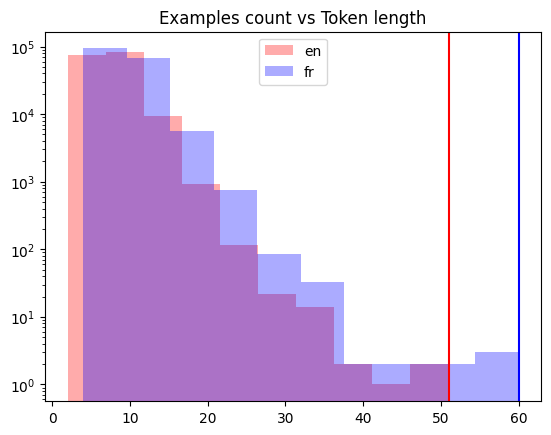

In [11]:
import matplotlib.pyplot as plt

# histogram of sentence length in tokens
en_lengths = [len(eng.split()) for eng, fra in text_pairs]
fr_lengths = [len(fra.split()) for eng, fra in text_pairs]

plt.hist(en_lengths, label="en", color="red", alpha=0.33)
plt.hist(fr_lengths, label="fr", color="blue", alpha=0.33)
plt.yscale("log")     # sentence length fits Benford"s law
plt.ylim(plt.ylim())  # make y-axis consistent for both plots
plt.plot([max(en_lengths), max(en_lengths)], plt.ylim(), color="red")
plt.plot([max(fr_lengths), max(fr_lengths)], plt.ylim(), color="blue")
plt.legend()
plt.title("Examples count vs Token length")
plt.show()

## Vecotization and Masking datasets

In [12]:
type(text_pairs)

list

In [22]:
text_pairs[1000]
## FORMAT
## tuple of size 2 (English, French)

('who is it ?', '[start] qui est-il  ?  [end]')

In [23]:
# Splitting dataset
# train-test-val split -> 70/15/15 Randomized
# shuffling the list
random.shuffle(text_pairs)

total = len(text_pairs)
n_val = int(0.15 * total)
n_train = total - 2 * n_val

train_pairs = text_pairs[:n_train]
val_pairs = text_pairs[n_train : n_train + n_val]
test_pairs = text_pairs[n_train + n_val :]

In [ ]:
Total English tokens: 14969
Total French tokens: 29219

In [24]:
from tensorflow.keras.layers import TextVectorization

# Parameter determined after analyzing the input data
vocab_size_en = 5000
vocab_size_fr = 10000
seq_length = 20

# Create vectorizer
eng_vectorizer = TextVectorization(
    max_tokens=vocab_size_en,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length,
)
fra_vectorizer = TextVectorization(
    max_tokens=vocab_size_fr,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length + 1
)

# train the vectorization layer using training dataset
train_eng_texts = [pair[0] for pair in train_pairs]
train_fra_texts = [pair[1] for pair in train_pairs]
eng_vectorizer.adapt(train_eng_texts)
fra_vectorizer.adapt(train_fra_texts)

# save for subsequent steps
# c
with open(os.path.join(PATH,"vectorize.pickle"), "wb") as fp:
    data = {
        "train": train_pairs,
        "val":   val_pairs,
        "test":  test_pairs,
        "engvec_config":  eng_vectorizer.get_config(),
        "engvec_weights": eng_vectorizer.get_weights(),
        "fravec_config":  fra_vectorizer.get_config(),
        "fravec_weights": fra_vectorizer.get_weights(),
    }
    pickle.dump(data, fp)

In [26]:
eng_vectorizer.dtype

keras.layers.preprocessing.text_vectorization.TextVectorization

In [25]:
type(data)

dict

above we make use of the vectorizer and created a TensorFlow Dataset object

## NEED TO CHECK

In [27]:
# import pickle

# import tensorflow as tf
# from tensorflow.keras.layers import TextVectorization

# # load text data and vectorizer weights
# with open("vectorize.pickle", "rb") as fp:
#     data = pickle.load(fp)

train_pairs = data["train"]
val_pairs = data["val"]
test_pairs = data["test"]   # not used

# 
eng_vectorizer = TextVectorization.from_config(data["engvec_config"])
eng_vectorizer.set_weights(data["engvec_weights"])
fra_vectorizer = TextVectorization.from_config(data["fravec_config"])
fra_vectorizer.set_weights(data["fravec_weights"])

# set up Dataset object
def format_dataset(eng, fra):
    """Take an English and a French sentence pair, convert into input and target.
    The input is a dict with keys `encoder_inputs` and `decoder_inputs`, each
    is a vector, corresponding to English and French sentences respectively.
    The target is also vector of the French sentence, advanced by 1 token. All
    vector are in the same length.

    The output will be used for training the transformer model. In the model we
    will create, the input tensors are named `encoder_inputs` and `decoder_inputs`
    which should be matched to the keys in the dictionary for the source part
    """
    eng = eng_vectorizer(eng)
    fra = fra_vectorizer(fra)
    source = {"encoder_inputs": eng,
              "decoder_inputs": fra[:, :-1]}
    target = fra[:, 1:]
    return (source, target)

def make_dataset(pairs, batch_size=64):
    """Create TensorFlow Dataset for the sentence pairs"""
    # aggregate sentences using zip(*pairs)
    eng_texts, fra_texts = zip(*pairs)
    # convert them into list, and then create tensors
    dataset = tf.data.Dataset.from_tensor_slices((list(eng_texts), list(fra_texts)))
    return dataset.shuffle(2048) \
                  .batch(batch_size).map(format_dataset) \
                  .prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

# test the dataset
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["encoder_inputs"][0]: {inputs["encoder_inputs"][0]}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"][0]: {inputs["decoder_inputs"][0]}')
    print(f"targets.shape: {targets.shape}")
    print(f"targets[0]: {targets[0]}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["encoder_inputs"][0]: [   6  582   21 2210   37  108 4371   21  456    1  668 3599   54  176
    2    0    0    0    0    0]
inputs["decoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"][0]: [   2 1453   17   10  217    1  423   17 7313 1046  130 1314   10  126
 7293    4    3    0    0    0]
targets.shape: (64, 20)
targets[0]: [1453   17   10  217    1  423   17 7313 1046  130 1314   10  126 7293
    4    3    0    0    0    0]


## Positional Encoding

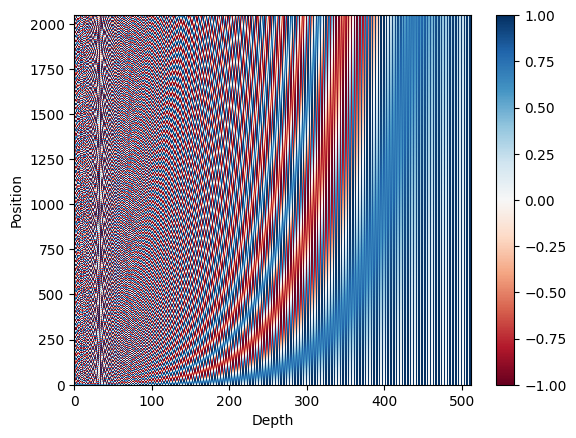

In [45]:
import pickle

import matplotlib.pyplot as plt
import numpy as np

def pos_enc_matrix(L, d, n = 10000):
  """ Creates positional encoding matrix

  Arguments:
      L: Input Dimention (length)
      d: Output Dimention (Depth) - Should be even
      n: Constant for sinusoidal functions
  
  Returns:
      numpy matrix of floats of dim Lxd. At element (k, 2i) the value is 
      sin(k / n ^ (2i/d)) while at element (k, 2i+1) the value is cos(k / n ^ (2i/d))
  """


  assert d % 2 == 0, "Output dimension needs to be an even integer"
  d2 = d//2
  P = np.zeros((L,d))
  k = np.arange(L).reshape(-1,1)    # Reshaping to column vector - L-column vector
  i = np.arange(d2).reshape(1,-1)   # Reshaping to column vector - d-row vector
  denom = np.power(n, -i/d2)        # n**(-2*i/d)
  args = k * denom
  P[:, ::2] = np.sin(args)
  P[:, 1::2] = np.cos(args)
  return P

# Plot the positional encoding matrix
pos_matrix = pos_enc_matrix(L=2048, d=512)
assert pos_matrix.shape == (2048, 512)
plt.pcolormesh(pos_matrix, cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()

with open(os.path.join(PATH, "posenc-2048-512.pickle"), "wb") as fp:
    pickle.dump(pos_matrix, fp)

In [46]:
# Seperating sin and cosine values

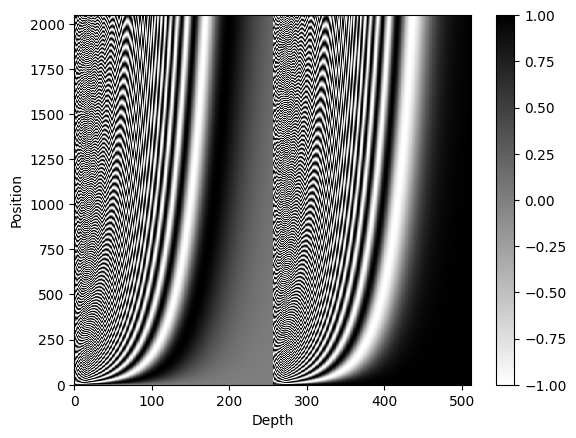

In [57]:
# Plot the positional encoding matrix, alternative way
plt.pcolormesh(np.hstack([pos_matrix[:, ::2], pos_matrix[:, 1::2]]), cmap='binary')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()

* different “depth” in the matrix represents a sine curve of different frequency

In [67]:
pos_matrix.shape

(2048, 512)

In [69]:
len(pos_matrix[300])

512

In [70]:
pos_matrix[300].shape

(512,)

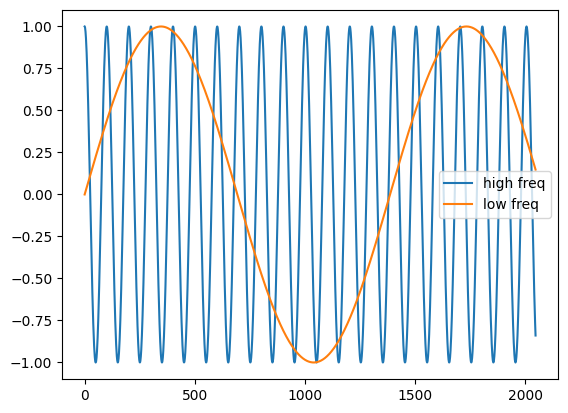

In [58]:
plt.plot(pos_matrix[:, 155], label="high freq")
plt.plot(pos_matrix[:, 300], label="low freq")
plt.legend()
plt.show()

* visualiing 

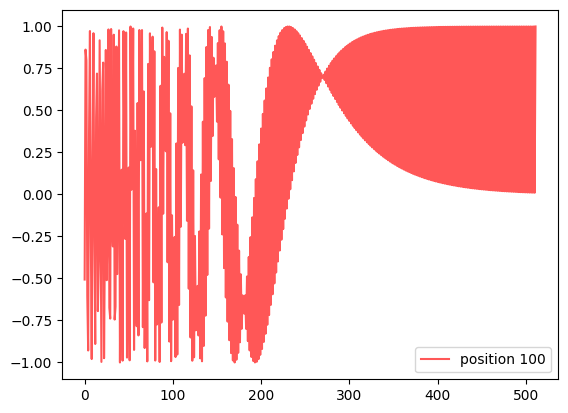

In [64]:
# Plot two curves from different position
plt.plot(pos_matrix[100], alpha=0.66, color="red", label="position 100")
plt.legend()
plt.show()

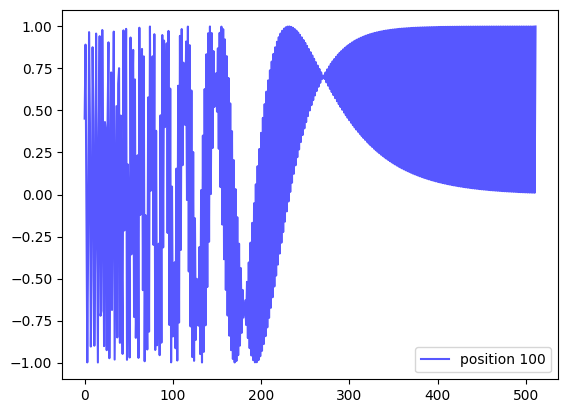

In [72]:
# Plot two curves from different position
plt.plot(pos_matrix[101], alpha=0.66, color="blue", label="position 100")
plt.legend()
plt.show()

>* Benifits of positional encoding


> The encoding matrix is useful in the sense that, when you compare two encoding vectors, you can tell how far apart their positions are. The dot-product of two normalized vectors is 1 if they are identical and drops quickly as they move apart.
This relationship can be visualized below:






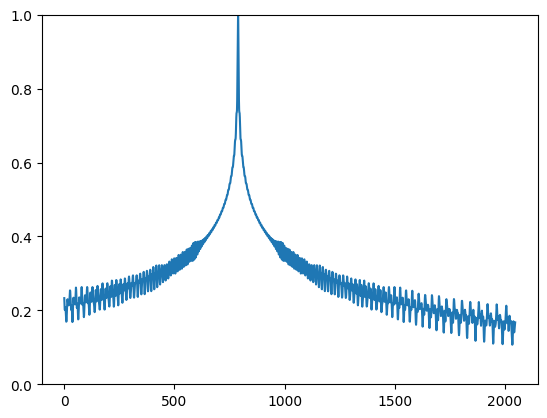

In [73]:
# Show the dot product between different normalized positional vectors
pos_matrix /= np.linalg.norm(pos_matrix, axis=1, keepdims=True)
p = pos_matrix[789]  # all vectors compare to vector at position 789
dots = pos_matrix @ p   # @ is matrix multiplication in python
plt.plot(dots)
plt.ylim([0, 1])
plt.show()

## Positional Encoding Layer

> Positional encoding is the first step in Transformer architecure

> Keras does not provide us by default Positional Encoding

> Here let us create Positional encoding layer from scratch



In [74]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """Positional embedding layer. Assume tokenized input, transform into
    embedding and returns positional-encoded output."""
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        """
        Args:
            sequence_length: Input sequence length
            vocab_size: Input vocab size, for setting up embedding matrix
            embed_dim: Embedding vector size, for setting up embedding matrix
        """
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim     # d_model in paper
        # token embedding layer: Convert integer token to D-dim float vector
        self.token_embeddings = tf.keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim, mask_zero=True
        )
        
        # positional embedding layer: a matrix of hard-coded sine values
        matrix = pos_enc_matrix(sequence_length, embed_dim)
        self.position_embeddings = tf.constant(matrix, dtype="float32")

    def call(self, inputs):
        """Input tokens convert into embedding vectors then superimposed
        with position vectors"""
        embedded_tokens = self.token_embeddings(inputs)
        return embedded_tokens + self.position_embeddings

    # this layer is using an Embedding layer, which can take a mask
    # see https://www.tensorflow.org/guide/keras/masking_and_padding#passing_mask_tensors_directly_to_layers
    def compute_mask(self, *args, **kwargs):
        return self.token_embeddings.compute_mask(*args, **kwargs)

    def get_config(self):
        # to make save and load a model using custom layer possible
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config

In [75]:
vocab_size_en = 5000
seq_length = 20

# test the dataset
for inputs, targets in train_ds.take(1):
    print(inputs["encoder_inputs"])
    embed_en = PositionalEmbedding(seq_length, vocab_size_en, embed_dim=512)
    en_emb = embed_en(inputs["encoder_inputs"])
    print(en_emb.shape)
    print(en_emb._keras_mask)

tf.Tensor(
[[ 11 441 180 ...   0   0   0]
 [  3  14 242 ...   0   0   0]
 [ 56   4  34 ...   0   0   0]
 ...
 [ 50  96 481 ...   0   0   0]
 [ 23 261  22 ...   0   0   0]
 [ 32 275   8 ...   0   0   0]], shape=(64, 20), dtype=int64)
(64, 20, 512)
tf.Tensor(
[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]], shape=(64, 20), dtype=bool)


## Transformer Building Blocks



> Self Attention Model



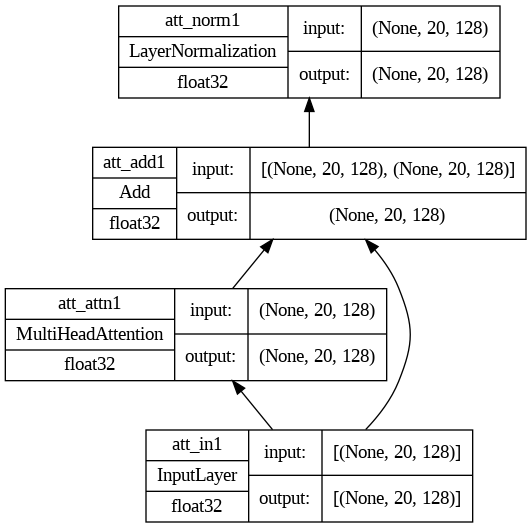

In [76]:
import tensorflow as tf

# Self_Attention Model using keras
def self_attention(input_shape, prefix="att", mask=False, **kwargs):
    """Self-attention layers at transformer encoder and decoder. Assumes its
    input is the output from positional encoding layer.

    Args:
        prefix (str): The prefix added to the layer names
        masked (bool): whether to use causal mask. Should be False on encoder and
                       True on decoder. When True, a mask will be applied such that
                       each location only has access to the locations before it.
    """
    # create layers
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in1")
    attention = tf.keras.layers.MultiHeadAttention(name=f"{prefix}_attn1", **kwargs)
    norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm1")
    add = tf.keras.layers.Add(name=f"{prefix}_add1")
    # functional API to connect input to output
    attout = attention(query=inputs, value=inputs, key=inputs,
                       use_causal_mask=mask)
    outputs = norm(add([inputs, attout]))
    # create model and return
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f"{prefix}_att")
    return model

seq_length = 20
key_dim = 128
num_heads = 8

model = self_attention(input_shape=(seq_length, key_dim),
                       num_heads=num_heads, key_dim=key_dim)
tf.keras.utils.plot_model(model, "self-attention.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

## 7

## 8

## 9 

## 10

## 11

## 12